In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from time import time
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as ET
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.ops import nms
import torchvision.transforms.functional as F

In [4]:
# Используем OpenCL устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Конфигурационные параметры
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_EPOCHS = 10
# Пути через pathlib
base_dir = Path('C:/Users/User/Desktop/Deep Learning/DataSet')
paths = {
    'train': (base_dir/'Train_Dataset/images', base_dir/'Train_Dataset/labels.csv'),
    'valid': (base_dir/'Valid_Dataset/images', base_dir/'Valid_Dataset/labels.csv'),
    'test': (base_dir/'Test_Dataset/images', base_dir/'Test_Dataset/labels.csv')
}

class ImageDataset(Dataset):
    def __init__(self, image_dir, label_path, transform=None, is_train=False, max_samples=None, shuffle=False, debug=False):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(label_path, header=None)
        self.labels_df.columns = ['row_number', 'filename', 'category_id', 'category_name']
        self.transform = transform
        self.debug = debug  

        # Используем category_id напрямую
        self.labels = self.labels_df['category_id'].values  

        # Ограничиваем количество загружаемых образцов
        if max_samples is not None:
            self.labels_df = self.labels_df.sample(n=max_samples, random_state=42)
            self.labels = self.labels_df['category_id'].values  # Обновляем метки

        # Если не требуется случайная выборка, оставляем порядок как есть
        if not shuffle:
            self.labels_df = self.labels_df.reset_index(drop=True)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.image_dir / self.labels_df.iloc[idx]['filename']
        image = read_image(str(img_path))

        if self.transform:
            image = self.transform(image)

        # Отладочный вывод
        if self.debug:  # Проверяем, включен ли отладочный режим
            print(f"Loading image: {img_path}, Label: {self.labels[idx]}, Category: {self.labels_df.iloc[idx]['category_name']}")

        return image, self.labels[idx]

Using device: cpu


In [3]:
# Создание отладочного датасета
debug_dataset = ImageDataset(*paths['train'], is_train=True,shuffle=False, debug=True)

# Пример загрузки нескольких изображений
for i in range(20):  # Проверяем первые 20 изображений
    image, label = debug_dataset[i]

Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000000.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000001.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000002.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000003.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000004.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Desktop\Deep Learning\DataSet\Train_Dataset\images\adapter_plate_triangular000005.jpg, Label: 1, Category: adapter_plate_triangular
Loading image: C:\Users\User\Deskt

In [11]:
# import random

# # Папка с изображениями
# image_folder = Path('C:/Users/User/Desktop/Deep Learning/DataSet/Train_Dataset/images')

# all_images = []
# max_samples = 10000  # Максимальное количество изображений для загрузки

# # Получаем список всех файлов изображений
# image_files = [filename for filename in os.listdir(image_folder) if filename.endswith('.png') or filename.endswith('.jpg')]

# # Если файлов больше, чем max_samples, выбираем случайные
# if len(image_files) > max_samples:
#     image_files = random.sample(image_files, max_samples)

# # Загружаем изображения
# for filename in image_files:
#     img = read_image(os.path.join(image_folder, filename)).float() / 255.0  # Приводим к [0, 1]
#     all_images.append(img)

# # Объединяем все изображения в один тензор
# all_images_tensor = torch.stack(all_images)  # Используем stack вместо cat

# # Рассчитываем mean и std
# mean = all_images_tensor.mean(dim=[0, 2, 3])  # Среднее по каналам, высоте и ширине
# std = all_images_tensor.std(dim=[0, 2, 3])      # Стандартное отклонение

# print(f'Mean: {mean}, Std: {std}')

In [15]:
# Нормализация и аугментация данных
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Преобразование в градации серого
    transforms.Resize((150, 150)),  # Изменение размера для модели
    # transforms.ToTensor()
    #transforms.Resize((720, 720)),  # Увеличиваем размер для последующей обрезки
    # transforms.RandomCrop(500),  # Обрезаем центральную часть
    # transforms.RandomCrop(600),  # Дополнительно 
    transforms.ColorJitter(brightness=0.7, contrast=0.6, saturation=0.8, hue=0.4),
    #transforms.RandomPosterize(bits=2),  # Случайное уменьшение глубины цвета
    #transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    # transforms.RandomRotation(10),  # Случайное вращение на угол
    transforms.ConvertImageDtype(torch.float32),  # Преобразование изображения в тип float32
    #transforms.Normalize(mean=[0.2088, 0.2088, 0.2090], std=[0.0364, 0.0364, 0.0377])  # Нормализация
 ])

In [16]:
# Создание датасетов
max_train_samples = 25000
max_valid_samples = 300
max_test_samples = 15000

# Создаем датасеты
train_dataset = ImageDataset(*paths['train'], transform=transform, is_train=True, max_samples=max_train_samples, debug=False)
valid_dataset = ImageDataset(*paths['valid'], transform=transform, max_samples=max_valid_samples, debug=False)
test_dataset = ImageDataset(*paths['test'], transform=transform, max_samples=max_test_samples, debug=False)

In [8]:
def show_images(dataset, title, num_classes=10, images_per_class=3):
    plt.figure(figsize=(15, 15))
    classes = dataset.labels_df['category_name'].unique()
    sampled_classes = np.random.choice(classes, num_classes, replace=False)

    for i, class_name in enumerate(sampled_classes):
        class_indices = dataset.labels_df[dataset.labels_df['category_name'] == class_name].index
        sampled_indices = np.random.choice(class_indices, images_per_class, replace=False)

        for j, idx in enumerate(sampled_indices):
            img, label = dataset[idx]
            img = img.permute(1, 2, 0).numpy()  # Изменяем порядок осей для отображения
            img = np.clip(img, 0, 1)  # Ограничиваем значения для корректного отображения
            plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
            plt.imshow(img)
            plt.title(f"{dataset.labels_df.iloc[idx]['filename']}\nКласс: {class_name}", pad=5)
            plt.axis('off')

    plt.suptitle(title)
    plt.show()

# # Визуализация аугментации
# def visualize_augmentation(dataset, num_classes=10, apply_transform=True):
#     plt.figure(figsize=(15, 15))
#     classes = dataset.labels_df['category_name'].unique()
#     sampled_classes = np.random.choice(classes, num_classes, replace=False)

#     for i, class_name in enumerate(sampled_classes):
#         class_indices = dataset.labels_df[dataset.labels_df['category_name'] == class_name].index
#         idx = np.random.choice(class_indices)

#         # Оригинальное изображение
#         img, _ = dataset[idx]
#         original_img = img.permute(1, 2, 0).numpy()
#         original_img = np.clip(original_img, 0, 1)

#         plt.subplot(num_classes, 2, i * 2 + 1)
#         plt.imshow(original_img)
#         plt.title(f"Оригинал\nКласс: {class_name}", pad=5)
#         plt.axis('off')

#         # Аугментированное изображение
#         if apply_transform:
#             augmented_img = dataset.transform(img).permute(1, 2, 0).numpy()
#         else:
#             augmented_img = original_img  # Если не применять трансформацию, используем оригинал

#         augmented_img = np.clip(augmented_img, 0, 1)

#         plt.subplot(num_classes, 2, i * 2 + 2)
#         plt.imshow(augmented_img)
#         plt.title(f"Аугментация\nКласс: {class_name}", pad=5)
#         plt.axis('off')

#     plt.suptitle("Сравнение оригинальных и аугментированных изображений")
#     plt.show()

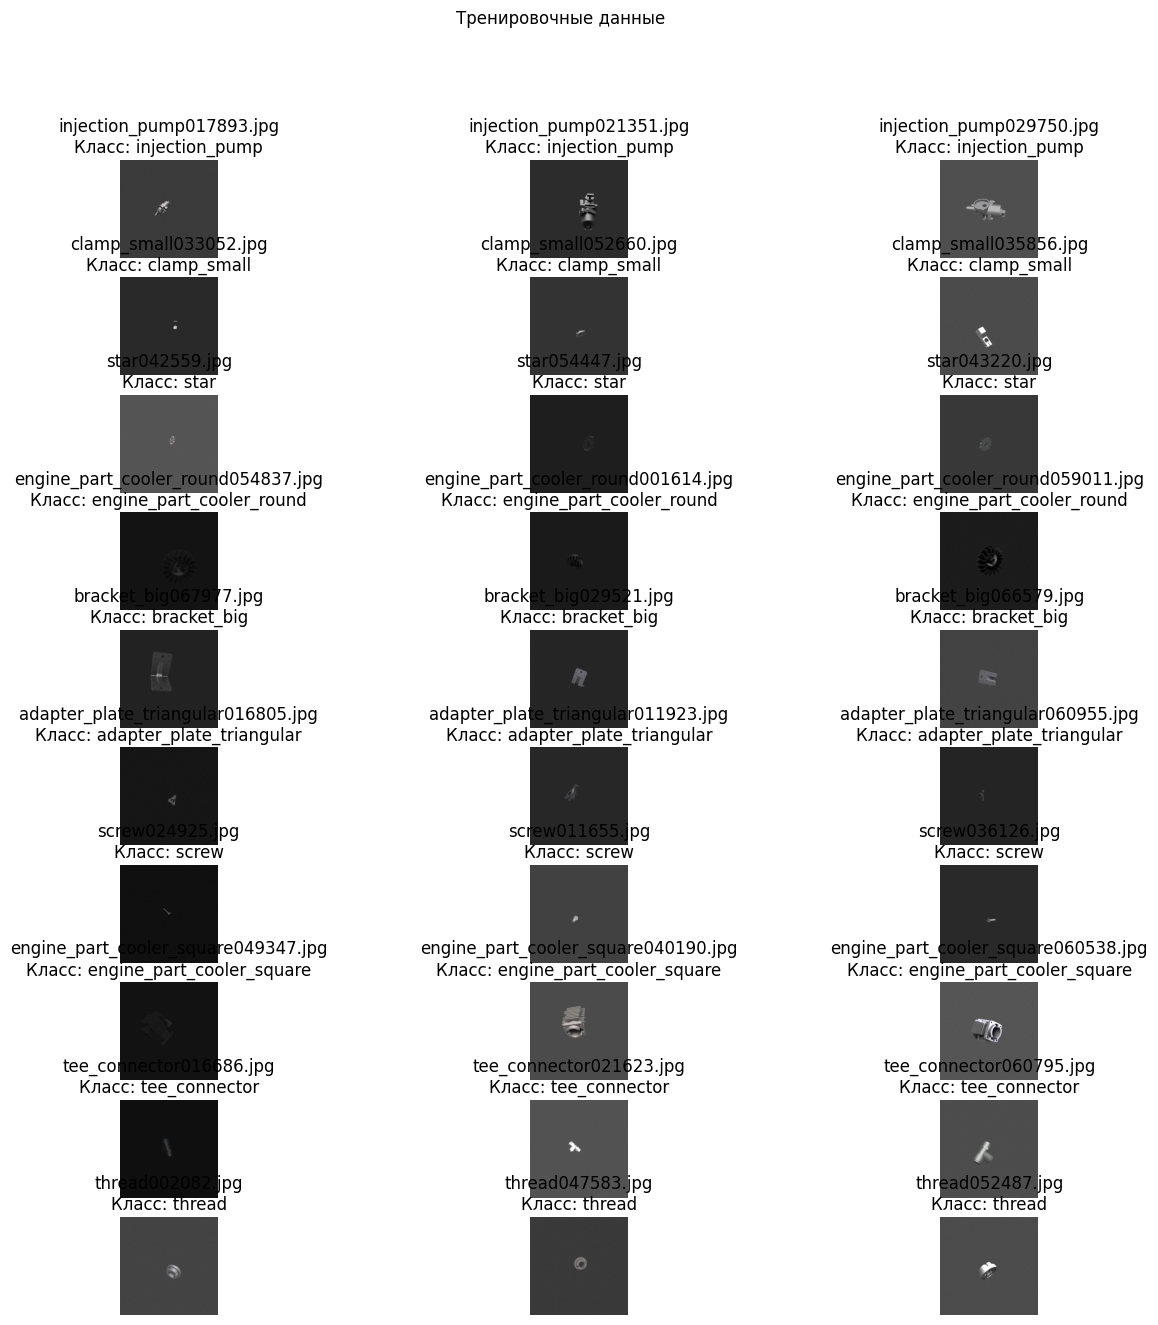

In [9]:
# Визуализация изображений для тренировочных, валидационных и тестовых наборов
show_images(train_dataset, "Тренировочные данные")
# show_images(valid_dataset, "Валидационные данные")
# show_images(test_dataset, "Тестовые данные")

In [17]:
def show_images_5x2_one_per_class(dataset, title, num_classes=10):
    plt.figure(figsize=(15, 6))  # Размер под 5x2

    classes = dataset.labels_df['category_name'].unique()
    sampled_classes = np.random.choice(classes, num_classes, replace=False)

    for i, class_name in enumerate(sampled_classes):
        # Ищем все индексы изображений данного класса
        class_indices = dataset.labels_df[dataset.labels_df['category_name'] == class_name].index
        # Выбираем случайный индекс из класса
        idx = np.random.choice(class_indices, 1)[0]

        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

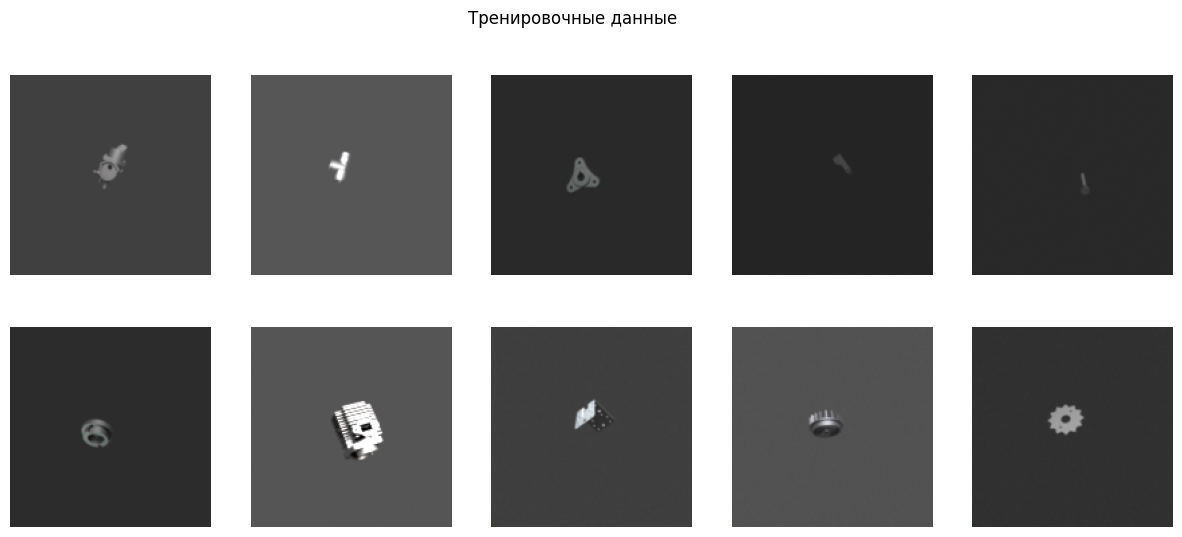

In [22]:
# Визуализация изображений для тренировочных, валидационных и тестовых наборов
show_images_5x2_one_per_class(train_dataset, "Тренировочные данные")

In [21]:
# visualize_augmentation(train_dataset, num_classes=10, apply_transform=False)  

In [88]:
# # Функция для вывода статистики о данных
# def print_data_statistics(dataset, dataset_name):
#     print(f"● {dataset_name} данные ●")
#     print(f"Общее количество: {len(dataset)}")
#     unique_classes = dataset.labels_df['category_name'].unique()
#     print(f"Уникальных классов: {len(unique_classes)}")

#     # Распределение классов
#     distribution = dataset.labels_df['category_name'].value_counts()
#     print("Распределение:")
#     for category, count in distribution.items():
#         print(f"{category:<30} {count}")
#     print("\n")

In [8]:
# Получаем количество уникальных классов
num_classes = len(np.unique(train_dataset.labels))
num_classes

10

In [68]:
# # Создание DataLoader'ов
# def create_loaders():

#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
#                              num_workers=NUM_WORKERS, pin_memory=True)
#     valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
#                              num_workers=NUM_WORKERS, pin_memory=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                             num_workers=NUM_WORKERS, pin_memory=True)

#     # Вывод статистики о данных
#     print_data_statistics(train_dataset, "Тренировочные")
#     print_data_statistics(valid_dataset, "Валидационные")
#     print_data_statistics(test_dataset, "Тестовые")

#     return train_loader, valid_loader, test_loader


# # Вызов функции create_loaders и получение датасетов
# train_loader, valid_loader, test_loader = create_loaders()

● Тренировочные данные ●
Общее количество: 1000
Уникальных классов: 10
Распределение:
engine_part_cooler_square      113
engine_part_cooler_round       109
thread                         107
screw                          100
bracket_big                    99
tee_connector                  96
clamp_small                    96
star                           96
injection_pump                 95
adapter_plate_triangular       89


● Валидационные данные ●
Общее количество: 300
Уникальных классов: 10
Распределение:
adapter_plate_triangular       37
star                           37
engine_part_cooler_square      32
engine_part_cooler_round       32
tee_connector                  31
screw                          29
injection_pump                 28
clamp_small                    26
thread                         26
bracket_big                    22


● Тестовые данные ●
Общее количество: 500
Уникальных классов: 10
Распределение:
screw                          59
tee_connector              

In [9]:
import cv2
print(cv2.__version__)

4.10.0


In [11]:
import xml.etree.ElementTree as ET
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.ops import nms
import torchvision.transforms.functional as F

device = torch.device("cpu")

# Загрузка предобученной модели
model = maskrcnn_resnet50_fpn(weights='DEFAULT')
model.eval().to(device)

# Функция для сегментации объектов
def segment_objects(image):
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(image_tensor)

    masks = predictions[0]['masks'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()

    # Отбираем маски с высоким уровнем уверенности
    high_confidence_indices = np.where(scores > 0.5)[0]
    high_confidence_masks = masks[high_confidence_indices]
    high_confidence_boxes = boxes[high_confidence_indices]
    high_confidence_scores = scores[high_confidence_indices]

    # Применяем NMS
    keep_indices = nms(torch.tensor(high_confidence_boxes), torch.tensor(high_confidence_scores), iou_threshold=0.5)

    return high_confidence_masks[keep_indices.numpy()], high_confidence_boxes[keep_indices.numpy()]

# Функция для сохранения XML аннотаций
def save_annotation(output_dir, idx, i, category_name):
    # Сохраняет аннотацию в формате XML
    import xml.etree.ElementTree as ET

    # Создаем корневой элемент
    annotation = ET.Element("annotation")

    # Создаем элемент Category
    category_element = ET.SubElement(annotation, "Category")
    category_element.text = f"Category: {category_name}"

    # Формируем путь к файлу
    output_file_path = os.path.join(output_dir, f"cropped_object_{idx}_{i}_{category_name}.xml")

    # Записываем XML в файл
    tree = ET.ElementTree(annotation)
    tree.write(output_file_path, encoding='utf-8', xml_declaration=True)

    print(f"Аннотация сохранена: {output_file_path}")

# Сохранение вырезанных объектов и их меток
def save_cropped_objects(dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(dataset)):
        img, labels = dataset[idx]  # Получаем изображение и метки
        img = img.permute(1, 2, 0).numpy() * 255  # Преобразуем в формат HWC и нормализуем
        img = img.astype(np.uint8)

        masks, boxes = segment_objects(img)

        for i, mask in enumerate(masks):
            binary_mask = mask[0] > 0.3  # Преобразуем в бинарную маску
            binary_mask = (binary_mask * 255).astype(np.uint8)

            # Создаем новое изображение с прозрачным фоном
            height, width = img.shape[:2]
            transparent_img = np.zeros((height, width, 4), dtype=np.uint8)  # Создаем изображение с 4 каналами (RGBA)

            # Копируем пиксели объекта в новое изображение
            transparent_img[..., :3][binary_mask > 0] = img[binary_mask > 0]  # Копируем RGB значения
            transparent_img[..., 3][binary_mask > 0] = 255  # Устанавливаем альфа-канал на 255 для непрозрачных пикселей

            # Устанавливаем альфа-канал на 0 для фона
            transparent_img[..., 3][binary_mask == 0] = 0  # Устанавливаем альфа-канал на 0 для фона

            # Получаем метку класса
            category_name = dataset.labels_df.iloc[idx]['category_name']  

            # Сохраняем вырезанный объект
            cropped_image_path = os.path.join(output_dir, f"cropped_object_{idx}_{i}_{category_name}.png")  # Сохраняем как PNG
            cv2.imwrite(cropped_image_path, transparent_img)
            print(f"Сохранено: {cropped_image_path}")

            # Сохраняем категории в формате XML
            save_annotation(output_dir, idx, i, category_name)

In [ ]:
# Пример использования
output_directory_train = 'C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/train'
# output_directory_valid = 'C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/valid'
output_directory_test = 'C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test'

# Сохранение вырезанных объектов
# save_cropped_objects(train_dataset, output_directory_train)
# save_cropped_objects(valid_dataset, output_directory_valid)
save_cropped_objects(test_dataset, output_directory_test)


Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_2_0_engine_part_cooler_square.png
Аннотация сохранена: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_2_0_engine_part_cooler_square.xml
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_6_0_injection_pump.png
Аннотация сохранена: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_6_0_injection_pump.xml
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_9_0_engine_part_cooler_square.png
Аннотация сохранена: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_9_0_engine_part_cooler_square.xml
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_10_0_bracket_big.png
Аннотация сохранена: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/test\cropped_object_10_0_bracket_big.xml
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects2/

In [21]:
from torchvision.utils import save_image

def create_soft_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Применяем метод Otsu для бинаризации
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Применяем размытие для создания мягкой маски
    soft_mask = cv2.GaussianBlur(binary_mask, (5, 5), 0)
    soft_mask = soft_mask / 255.0
    return soft_mask

def preprocess_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

#def enhance_contrast(image):
    # lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # l, a, b = cv2.split(lab)
    # clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(9, 9))
    # cl = clahe.apply(l)
    # limg = cv2.merge((cl, a, b))
    # return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def crop_object(image):
    img_bgr = image.permute(1, 2, 0).numpy() * 255
    img_bgr = img_bgr.astype(np.uint8)
    # img_bgr = enhance_contrast(img_bgr)
    
    soft_mask = create_soft_mask(img_bgr)
    soft_mask = preprocess_mask((soft_mask * 255).astype(np.uint8))
   
    
    # Находим контуры
    contours, _ = cv2.findContours(soft_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

        masked_img = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_img = masked_img[y:y+h, x:x+w]

        if cropped_img.shape[2] == 3:
            alpha_channel = (soft_mask[y:y+h, x:x+w] * 255 * 1.2).astype(np.uint8)  # Используем мягкую маску
            cropped_img = np.dstack((cropped_img, alpha_channel))

        cropped_img_tensor = torch.from_numpy(cropped_img).permute(2, 0, 1).float() / 255.0
        return cropped_img_tensor
    else:
        return None

def save_cropped_objects(dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(dataset)):
        img, label = dataset[idx]
        cropped_img = crop_object(img)

        if cropped_img is not None:
            save_path = os.path.join(output_dir, f"cropped_object_{idx}.png")
            save_image(cropped_img, save_path)
            print(f"Сохранено: {save_path}")
        else:
            print(f"Объект не найден для изображения с индексом {idx}")

In [22]:
# Пример использования
output_directory = 'C:/Users/User/Desktop/Deep Learning/Cropped_Objects'
save_cropped_objects(train_dataset, output_directory)

Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_0.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_1.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_2.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_3.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_4.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_5.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_6.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_7.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_8.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_9.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_object_10.png
Сохранено: C:/Users/User/Desktop/Deep Learning/Cropped_Objects\cropped_obje

KeyboardInterrupt: 

In [33]:
# from torchvision.models.detection import maskrcnn_resnet50_fpn
# from torchvision.transforms import functional as F
# from torchvision.ops import nms

# # Загрузка модели Mask R-CNN
# model = maskrcnn_resnet50_fpn(weights=True)
# model.eval()  # Устанавливаем модель в режим оценки

# # Устройство для вычислений
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# def segment_objects(image):
#     # Преобразуем изображение в формат, который принимает Mask R-CNN
#     img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     img = torch.from_numpy(img).float().to(device) / 255.0  # Нормализуем
#     img = img.permute(2, 0, 1).unsqueeze(0)  # Преобразуем в тензор

#     with torch.no_grad():
#         predictions = model(img)  # Получаем предсказания

#     masks = []
#     boxes = []
#     scores = []
#     labels = []

#     # Обрабатываем результаты
#     for i in range(len(predictions[0]['masks'])):
#         mask = predictions[0]['masks'][i, 0].cpu().numpy()
#         score = predictions[0]['scores'][i].cpu().numpy()
#         box = predictions[0]['boxes'][i].cpu().numpy()
#         label = predictions[0]['labels'][i].cpu().numpy()

#         if score > 0.25:  # Порог уверенности
#             masks.append(mask)
#             boxes.append(box)
#             scores.append(score)
#             labels.append(label)

#     return np.array(masks), np.array(boxes), np.array(scores), np.array(labels)

# # Сохранение вырезанных объектов и их меток
# def save_cropped_objects(dataset, output_dir):
#     os.makedirs(output_dir, exist_ok=True)

#     for idx in range(len(dataset)):
#         img, _ = dataset[idx]  # Получаем изображение
#         img = img.permute(1, 2, 0).numpy() * 255  # Преобразуем в формат HWC и нормализуем
#         img = img.astype(np.uint8)

#         masks, boxes, scores, labels = segment_objects(img)

#         for i, mask in enumerate(masks):
#             binary_mask = mask > 0.4  # Преобразуем в бинарную маску

#             # Создаем новое изображение с прозрачным фоном
#             height, width = img.shape[:2]
#             transparent_img = np.zeros((height, width, 4), dtype=np.uint8)  # Создаем изображение с 4 каналами (RGBA)

#             # Копируем пиксели объекта в новое изображение
#             transparent_img[..., :3][binary_mask] = img[binary_mask]  # Копируем RGB значения
#             transparent_img[..., 3][binary_mask] = 255  # Устанавливаем альфа-канал на 255 для непрозрачных пикселей
#             transparent_img[..., 3][~binary_mask] = 0  # Устанавливаем альфа-канал на 0 для фона
            
#             # Получаем метку класса
#             category_name = f"class_{labels[i]}"  # Здесь можно заменить на реальные названия классов

#             # Сохраняем вырезанный объект
#             cropped_image_path = os.path.join(output_dir, f"cropped_object_{idx}_{i}_{category_name}.png")  # Сохраняем как PNG
#             cv2.imwrite(cropped_image_path, transparent_img)
#             print(f"Сохранено: {cropped_image_path}")

#             # Сохраняем метки классов
#             with open(os.path.join(output_dir, f"cropped_object_{idx}_{i}_{category_name}.txt"), 'w') as f:
#                 f.write(f"Category: {category_name}\n")

#             # Пример отладочного вывода
#             print(f"Обрабатываем маску {i} с размером: {mask.shape}")
#             if np.sum(mask) == 0:
#                 print("Маска пуста, объект не найден.")
#             else:
#                 print("Объект найден, продолжаем обработку.")


In [34]:
# Загрузка предобученной модели DeepLabV3+
model = models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT')
model.eval()

# Преобразование для входных изображений
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Изменение размера для модели
    transforms.ToTensor(),
])

def create_soft_mask(image):
    # Применяем DeepLabV3+ для получения маски
    input_tensor = preprocess(image).unsqueeze(0)  # Добавляем размерность для батча
    with torch.no_grad():
        output = model(input_tensor)['out'][0]  # Получаем выход модели
    output_predictions = output.argmax(0).byte().cpu().numpy()  # Получаем предсказание класса

    print(f"Предсказания для изображения: {np.unique(output_predictions)}")  # Вывод уникальных классов
    
    # Создаем бинарную маску для всех классов
    binary_mask = (output_predictions >= 0.5).astype(np.uint8) * 255  # Все классы кроме фона
    soft_mask = cv2.GaussianBlur(binary_mask, (5, 5), 0)
    soft_mask = soft_mask / 255.0
    return soft_mask

def preprocess_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def crop_object(image):
    img_bgr = image.permute(1, 2, 0).numpy() * 255
    img_bgr = img_bgr.astype(np.uint8)
    
    soft_mask = create_soft_mask(img_bgr)
    soft_mask = preprocess_mask((soft_mask * 255).astype(np.uint8))
    
     # Находим контуры
    contours, _ = cv2.findContours(soft_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros(img_bgr.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

        masked_img = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_img = masked_img[y:y+h, x:x+w]

        if cropped_img.shape[2] == 3:
            alpha_channel = (soft_mask[y:y+h, x:x+w] * 255).astype(np.uint8)  # Используем мягкую маску
            cropped_img = np.dstack((cropped_img, alpha_channel))

        cropped_img_tensor = torch.from_numpy(cropped_img).permute(2, 0, 1).float() / 255.0
        return cropped_img_tensor
    else:
        return None

def save_cropped_objects_v2(dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(dataset)):
        img, label = dataset[idx]
        cropped_img = crop_object(img)

        if cropped_img is not None:
            # Используем category_id для именования файлов
            save_path = os.path.join(output_dir, f"cropped_object_{label}_{idx}.png")
            save_image(cropped_img, save_path)
            print(f"Сохранено: {save_path}")
        else:
            print(f"Объект не найден для изображения с индексом {idx}")


NameError: name 'models' is not defined

In [36]:
# Пример использования
output_directory = 'C:/Users/User/Desktop/Deep Learning/Cropped_Objects_v2'
save_cropped_objects_v2(train_dataset, output_directory)

NameError: name 'save_cropped_objects_v2' is not defined

In [79]:
# Создание DataLoader'ов
def create_loaders():

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=NUM_WORKERS, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS, pin_memory=True)

    # Вывод статистики о данных
    print_data_statistics(train_dataset, "Тренировочные")
    print_data_statistics(valid_dataset, "Валидационные")
    print_data_statistics(test_dataset, "Тестовые")

    return train_loader, valid_loader, test_loader


# Вызов функции create_loaders и получение датасетов
train_loader, valid_loader, test_loader = create_loaders()

● Тренировочные данные ●
Общее количество: 1000
Уникальных классов: 10
Распределение:
engine_part_cooler_square      113
engine_part_cooler_round       109
thread                         107
screw                          100
bracket_big                    99
tee_connector                  96
clamp_small                    96
star                           96
injection_pump                 95
adapter_plate_triangular       89


● Валидационные данные ●
Общее количество: 300
Уникальных классов: 10
Распределение:
adapter_plate_triangular       37
star                           37
engine_part_cooler_square      32
engine_part_cooler_round       32
tee_connector                  31
screw                          29
injection_pump                 28
clamp_small                    26
thread                         26
bracket_big                    22


● Тестовые данные ●
Общее количество: 500
Уникальных классов: 10
Распределение:
screw                          59
tee_connector              